<a href="https://colab.research.google.com/github/shielamms/Tensorflow-Notebooks/blob/main/Statistical_Forecasting_with_Synthetic_Time_Series_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

## Plotting function

In [21]:
def plot_series(time, series, format='-', start=0, end=None, figsize=(10,6)):
  plt.figure(figsize=figsize)

  if isinstance(series, tuple):
    for s in series:
      plt.plot(time[start:end], s[start:end], format)
  else:
    plt.plot(time[start:end], series[start:end], format)

  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.grid(True)
  plt.show()

## Synthetic Time Series Data Generators

In [3]:
def trend(time, slope=0):
  """
  Generate synthetic time series data following a straight line of a given slope
  """

  return slope * time

In [5]:
def seasonality(time, period, amplitude=1, phase=0):
  """
  Repeat an arbitrary pattern at each period
  """

  def seasonal_pattern(season_time):
    """
    Generate an arbitrary pattern simulating a seasonal pattern
    """
    pattern = np.where(season_time < 0.4,
                      np.cos(season_time * 2 * np.pi),
                      1 / np.exp(3 * season_time))
    return pattern
  
  season_time = ((time + phase) % period) / period
  data_pattern = amplitude * seasonal_pattern(season_time)
  return data_pattern


In [8]:
def noise(time, noise_level=1, seed=None):
  """
  Generate normally distributed noisy data
  """

  rnd = np.random.RandomState(seed)
  noise = rnd.randn(len(time)) * noise_level
  return noise

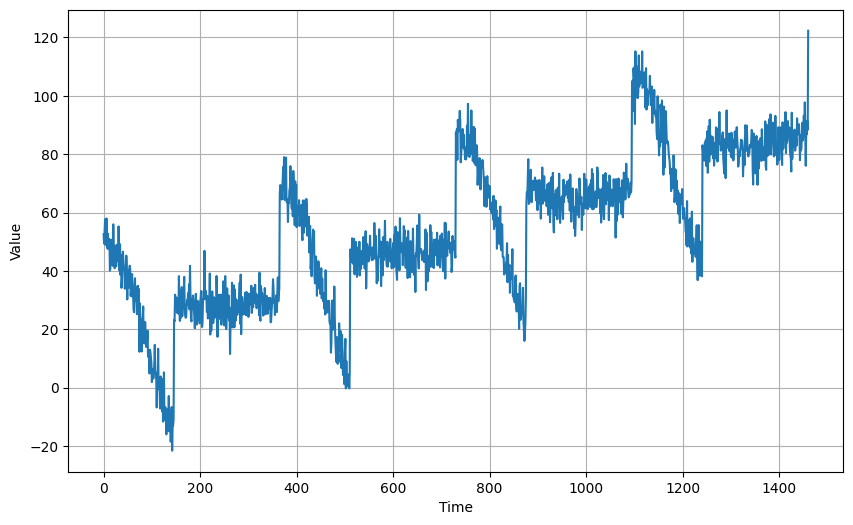

In [9]:
time = np.arange(4 * 365 + 1, dtype='float32')
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

series = (
    baseline
    + trend(time, slope)
    + seasonality(time, period=365, amplitude=amplitude)
)

series += noise(time, noise_level, seed=42)

plot_series(time, series)

## Splitting the dataset

In [16]:
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

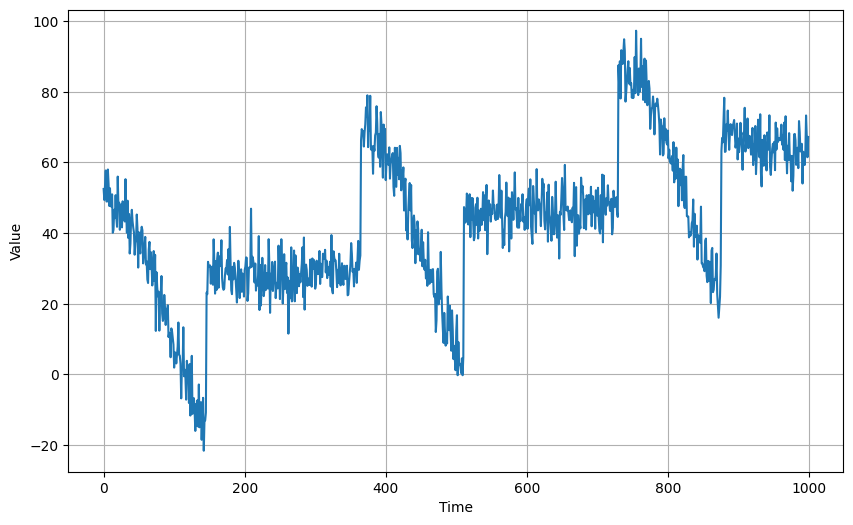

In [17]:
plot_series(time_train, x_train)

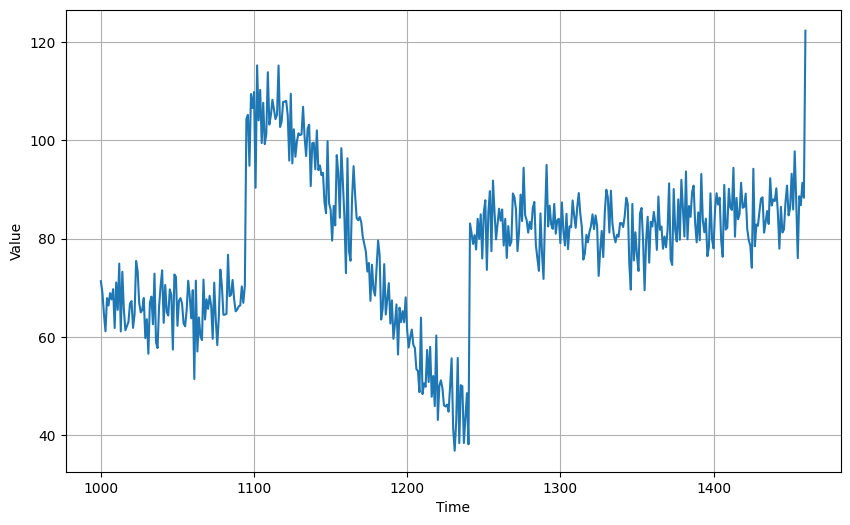

In [18]:
plot_series(time_valid, x_valid)

## Metrics

In [33]:
def compute_error(x_valid, forecast):
  print(f'Mean squared error: {tf.keras.metrics.mean_squared_error(x_valid, forecast).numpy()}')
  print(f'Mean absolute error: {tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()}')

## Naive Forecast

As a baseline forecast, assume that the value at time t is the same as the value at time t-1

In [19]:
naive_forecast = series[split_time - 1:-1]

time_step = 100

print(f'Value at time step {time_step}: {x_valid[time_step]}')
print(f'Prediction at time step {time_step + 1}: {naive_forecast[time_step + 1]}')

Value at time step 100: 109.84197998046875
Prediction at time step 101: 109.84197998046875


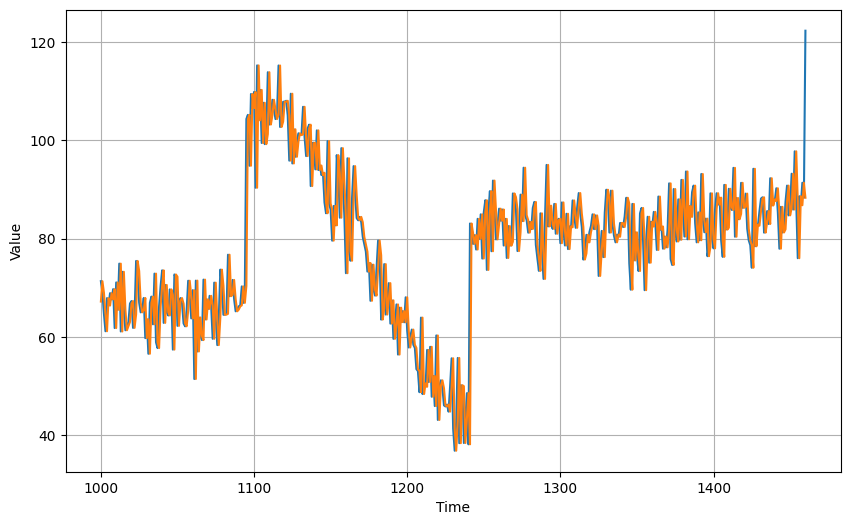

In [22]:
plot_series(time_valid, (x_valid, naive_forecast))

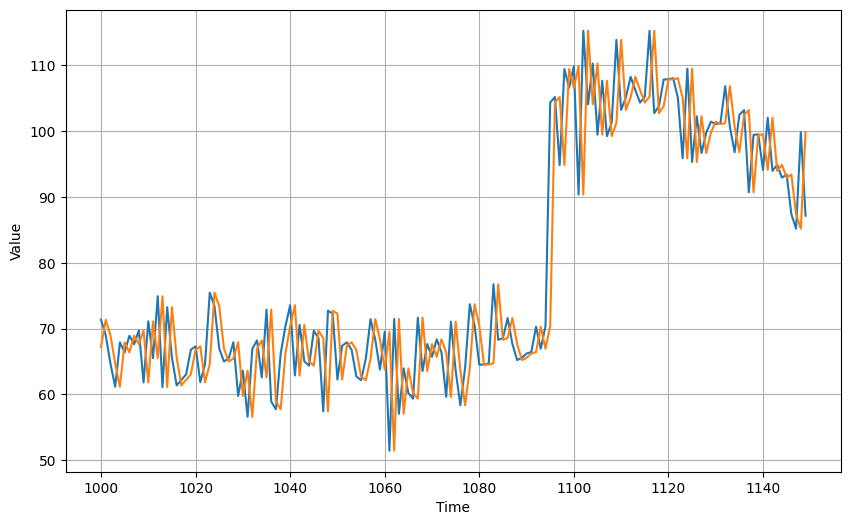

In [24]:
plot_series(time_valid, (x_valid, naive_forecast), start=0, end=150)

In [34]:
compute_error(x_valid, naive_forecast)

Mean squared error: 61.82753372192383
Mean absolute error: 5.937908172607422


## Moving average

In [28]:
def moving_average_forecast(series, window_size):
  forecast = []

  for time in range(len(series) - window_size):
    forecast.append(series[time:time+window_size].mean())

  forecast = np.array(forecast)

  return forecast

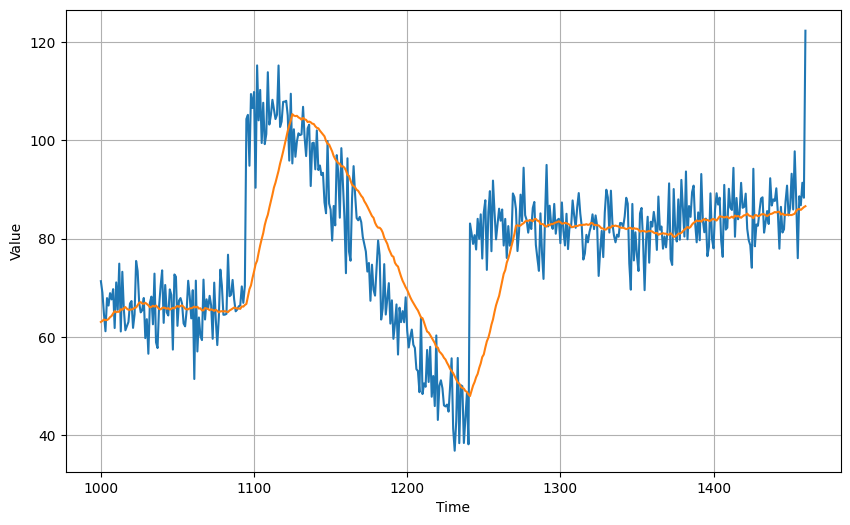

In [30]:
window_size = 30

moving_avg = moving_average_forecast(series, window_size)[split_time-window_size:]

plot_series(time_valid, (x_valid, moving_avg))

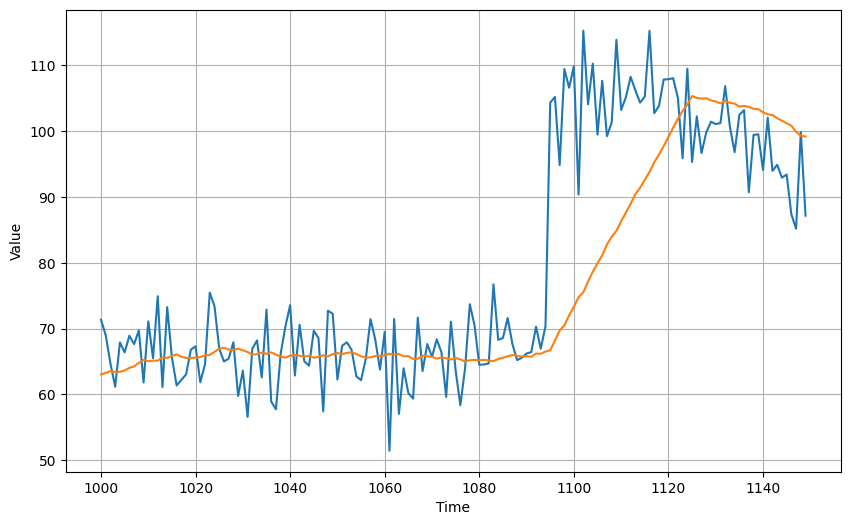

In [31]:
plot_series(time_valid, (x_valid, moving_avg), start=0, end=150)

In [35]:
compute_error(x_valid, moving_avg)

Mean squared error: 106.67457580566406
Mean absolute error: 7.14241886138916
